# PINN to model guitar string

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# PDE parameter (wave speed)
c = 1.0

# Collocation (PDE) points: where we evaluate the PDE residual
N_colloc = 20000
t_colloc = torch.rand((N_colloc, 1), device=device)    # random times in time domain [0,1]
x_colloc = torch.rand((N_colloc, 1), device=device)    # random positions in space domain [0,1]
tx_colloc = torch.cat([t_colloc, x_colloc], dim=1)     # shape (N_colloc, 2)

# Initial condition u(0,x) = sin(pi * x)
N_ic = 200
x_ic = torch.rand((N_ic, 1), device=device)             # random positions on string at t=0
t_ic = torch.zeros((N_ic, 1), device=device)            # t=0 for initial conditions
u_ic = torch.sin(np.pi * x_ic)                          # string displacement during initial condition
tx_ic = torch.cat([t_ic, x_ic], dim=1)                  # concatenated input (t,x) for initial condition

# Boundary conditions u(t,0)=0 and u(t,1)=0 (Dirichlet)
N_bc = 200
t_bc = torch.rand((N_bc, 1), device=device)            # random times for boundary conditions
x_bc_left = torch.zeros((N_bc, 1), device=device)   # left boundary at x=0
x_bc_right = torch.ones((N_bc, 1), device=device)   # right boundary at x=1
tx_bc_left = torch.cat([t_bc, x_bc_left], dim=1)    # concatenated input (t,x) for left boundary (left end of string)
tx_bc_right = torch.cat([t_bc, x_bc_right], dim=1)  # concatenated input (t,x) for right boundary (right end of string)
bc_left = torch.zeros((N_bc, 1), device=device)     # boundary condition value at left boundary (u(t,0)=0)
bc_right = torch.zeros((N_bc, 1), device=device)    # boundary condition value at right boundary (u(t,1)=0)

In [4]:
def derivative(u, inputs, dim, order=1):
    """
    Compute ∂^order u / ∂inputs[:, dim]^order using autograd.
    u: (batch,1) tensor output of model for inputs (batch,2)
    inputs: (batch,2) tensor with requires_grad=True
    dim: index 0 for t, 1 for x
    order: derivative order (1 or 2)
    returns: derivative tensor (batch,1)
    """
    out = u
    for _ in range(order):
        grads = torch.autograd.grad(
            out, inputs,
            grad_outputs=torch.ones_like(out),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]  # grads shape: (batch, 2)
        out = grads[:, dim:dim+1]  # select derivative w.r.t. chosen input column
    return out

In [5]:
def compute_loss(model, lambda1=1.0, lambda2=1.0, lambda3=1.0):
    """
    Compute total PINN loss with weights:
    - lambda1 * loss_pde : MSE of PDE residual
    - lambda2 * loss_ic  : MSE of initial condition
    - lambda3 * loss_bc  : MSE of boundary conditions

    Default weights = 1.

    Returns:
        total_loss (tensor)
        loss_pde.item(), loss_ic.item(), loss_bc.item()
    """
    # collocation points require gradients
    tx = tx_colloc.clone().requires_grad_(True)
    u_pred = model(tx)

    # second derivatives for wave equation
    u_tt = derivative(u_pred, tx, dim=0, order=2)
    u_xx = derivative(u_pred, tx, dim=1, order=2)

    # PDE residual: u_tt - c^2 u_xx = 0
    residual = u_tt - (c**2) * u_xx
    loss_pde = torch.mean(residual**2)

    # initial condition loss
    u_pred_ic = model(tx_ic)
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    # boundary conditions loss
    loss_bc  = torch.mean((model(tx_bc_left)  - bc_left)**2)
    loss_bc += torch.mean((model(tx_bc_right) - bc_right)**2)

    # weighted total loss
    total_loss = lambda1 * loss_pde + lambda2 * loss_ic + lambda3 * loss_bc

    return total_loss, loss_pde.item(), loss_ic.item(), loss_bc.item()


In [6]:
# PINN
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        # build a simple fully-connected MLP given layer sizes list
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, tx):
        """
        tx: tensor shape (batch, 2) where columns are [t, x]
        returns: u(t,x) prediction (batch,1)
        """
        z = tx
        for i in range(len(self.layers)-1):
            z = self.activation(self.layers[i](z))
        return self.layers[-1](z)

In [7]:
model = PINN([2, 64, 64, 64, 64, 1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, lpde, lic, lbc = compute_loss(model)
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss = {total_loss.item():.6f}, PDE={lpde:.6f}, IC={lic:.6f}, BC={lbc:.6f}")

/home/patrick/miniconda3/envs/comp_optics/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss = 0.473531, PDE=0.000020, IC=0.472557, BC=0.000954
Epoch 500, Loss = 0.001424, PDE=0.000571, IC=0.000159, BC=0.000694
Epoch 1000, Loss = 0.000612, PDE=0.000263, IC=0.000069, BC=0.000281
Epoch 1500, Loss = 0.000407, PDE=0.000174, IC=0.000043, BC=0.000190
Epoch 2000, Loss = 0.000464, PDE=0.000093, IC=0.000124, BC=0.000246
Epoch 2500, Loss = 0.006396, PDE=0.000176, IC=0.002460, BC=0.003760
Epoch 3000, Loss = 0.000134, PDE=0.000051, IC=0.000027, BC=0.000056
Epoch 3500, Loss = 0.000093, PDE=0.000037, IC=0.000023, BC=0.000032
Epoch 4000, Loss = 0.000082, PDE=0.000033, IC=0.000020, BC=0.000029
Epoch 4500, Loss = 0.002329, PDE=0.000131, IC=0.000766, BC=0.001432


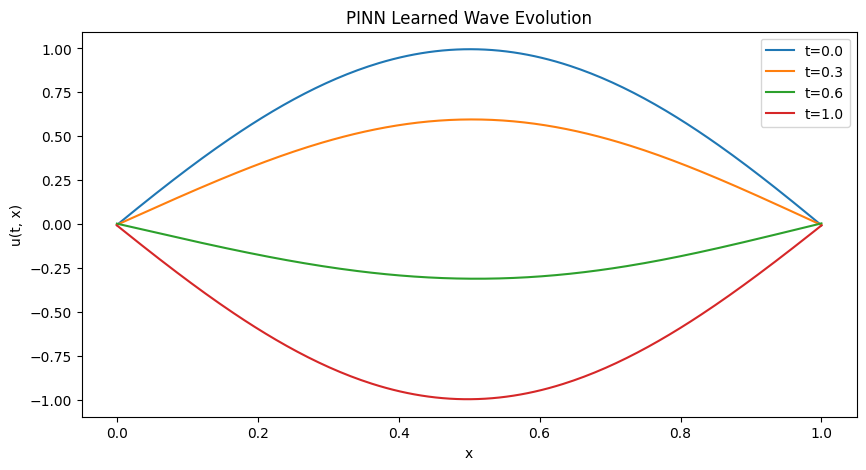

In [8]:
def plot_solution(t_val):
    x = torch.linspace(0,1,200).unsqueeze(1).to(device)
    t = torch.ones_like(x)*t_val
    tx = torch.cat([t,x], dim=1)
    u_pred = model(tx).detach().cpu().numpy()

    plt.plot(x.cpu(), u_pred, label=f"t={t_val}")
    plt.xlabel("x")
    plt.ylabel("u(t, x)")
    plt.legend()

plt.figure(figsize=(10,5))
plot_solution(0.0)
plot_solution(0.3)
plot_solution(0.6)
plot_solution(1.0)
plt.title("PINN Learned Wave Evolution")
plt.show()
